**Import and Install Packages**

In [1]:
# Necessary to read data files
import Pkg; Pkg.add("Parquet")
Pkg.add("DataFrames")
import LinearAlgebra; Pkg.add("LinearAlgebra")
Pkg.add("CSV")

    Updating registry at `C:\Users\sarah\.julia\registries\General.toml`
   Resolving package versions...
   Installed PDMats ──────── v0.11.31
   Installed Distributions ─ v0.25.104
  No Changes to `C:\Users\sarah\.julia\environments\v1.9\Project.toml`
    Updating `C:\Users\sarah\.julia\environments\v1.9\Manifest.toml`
  [31c24e10] ↑ Distributions v0.25.103 ⇒ v0.25.104
  [90014a1f] ↑ PDMats v0.11.30 ⇒ v0.11.31
⌅ [1d5cc7b8] ↓ IntelOpenMP_jll v2024.0.0+0 ⇒ v2023.2.0+0
        Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated -m`
Precompiling project...
  ✓ PDMats
  ✓ IntelOpenMP_jll
  ✓ FillArrays → FillArraysPDMatsExt
  ✓ MKL_jll
  ✓ Optim
  ✓ Distributions
  ✓ Distributions → DistributionsTestExt
  ✓ Distributions → DistributionsChainRulesCoreExt
  ✓ SimpleRandom
  ✓ SimpleGraphs
  ✓ DelaunayTriangulation
  ✓ FFTW
  ✓ FFTViews
  ✓ Polynomials → PolynomialsFFTWExt
  ✓ KernelDensity
  ✓ 

**Import Packages**

In [51]:
using DataFrames, Statistics, Plots
using LinearAlgebra, Printf, CSV, DelimitedFiles

**Read, Analyze, and Format Data**

_There appears to be a bug in the Parquet library in Julia when dealing with batching larger files,
so we opted for saving the analyzed, cut-down data into a CSV file using Python. We included the code in parse_data.ipynb for comprehensiveness._

In [6]:
# Read file + push into dataframe
path = "nk_cells.csv" # single-cell-perturbations/

dframe = DataFrame(CSV.File(path, normalizenames=true))
dframe

Row,Column1,sm_name,cell_type,A1BG,A1BG_AS1,A2M,A2M_AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATBC,AATF,AATK,ABALON,ABAT,ABCA1,ABCA10,ABCA11P,ABCA2,ABCA3,ABCA5,ABCA6,ABCA7,ABCA9,ABCB1,ABCB10,ABCB11,ABCB4,ABCB7,ABCB8,ABCB9,ABCC1,ABCC10,ABCC2,ABCC3,ABCC4,ABCC5,ABCD1,ABCD2,ABCD3,ABCD4,ABCE1,ABCF1,ABCF2,ABCF3,ABCG1,ABCG2,ABCG8,ABHD1,ABHD10,ABHD11,ABHD12,ABHD13,ABHD14A,ABHD14A_ACY1,ABHD14B,ABHD15,ABHD15_AS1,ABHD16A,ABHD17A,ABHD17B,ABHD17C,ABHD18,ABHD2,ABHD3,ABHD4,ABHD5,ABHD6,ABHD8,ABI1,ABI2,ABI3,ABL1,ABL2,ABLIM1,ABLIM2,ABO,ABR,ABRACL,ABRAXAS1,ABRAXAS2,ABT1,ABTB1,ABTB2,AC000068_1,AC000123_2,AC000123_3,AC000403_1,⋯
,Int64,String,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,0,Clotrimazole,1,0.10472,-0.0775242,-1.6256,-0.144545,0.143555,0.0732287,-0.0168228,0.101717,-0.00515259,1.04363,0.184753,0.376145,0.088934,0.716527,-0.00458806,-0.126706,-2.67015,0.624403,0.415386,-0.00199731,0.514184,-0.00177734,0.758135,0.472499,0.322558,0.213814,0.120027,-0.223165,0.442511,0.331059,-0.0540091,-0.0316914,0.53522,-0.0727683,-0.686676,-0.398824,0.282964,-0.221918,-0.0819851,0.131687,-0.537974,0.539864,0.244433,0.500311,0.375458,-0.0642481,-0.0395403,-0.698545,0.0884004,0.163427,0.31863,0.54952,-0.453874,0.594192,0.289537,0.250288,1.85945,0.713991,0.486583,1.51628,0.521259,0.0385376,0.0215441,0.458575,0.0326279,-0.716768,0.507417,0.267903,0.455896,-1.5372,-0.405862,-0.668558,-0.769305,-0.102722,-0.203382,0.357481,0.0486849,0.0221035,1.09819,0.575925,0.0691723,-0.220099,0.0135827,-0.728972,0.210118,0.573761,-0.217136,-0.49392,0.303003,-0.003237,-0.939268,0.167351,0.365755,0.709133,-0.604489,-0.847835,0.56419,⋯
2,4,Mometasone Furoate,1,4.29065,-0.0638636,-0.0174432,-0.541154,0.570982,2.02283,0.600011,1.23128,0.236739,0.338703,0.600942,0.0366232,-0.0359231,0.528092,0.854298,1.17943,-0.898467,0.130078,0.224189,1.80121,-0.816469,1.41082,0.838015,-1.1079,0.152169,1.79542,-0.265526,0.169314,0.396347,0.80171,1.51718,1.47998,4.2239,2.81755,-0.196344,1.84089,0.859217,-0.256717,-0.258033,0.497476,1.00086,-0.0506861,2.73675,0.523249,-0.00823142,-0.0183054,-0.432881,-3.68822,-1.02644,-0.0409843,-1.22062,-2.88055,-0.522876,1.39343,-1.78468,-0.0568258,0.0290527,1.13383,-0.00982334,0.477876,0.330134,-0.552146,-0.470891,1.42467,-0.151858,0.1404,0.93288,-0.681092,-2.57045,0.150965,-0.17634,2.80888,-0.311414,0.144678,-0.220863,1.70811,0.869606,-0.165215,-0.989548,0.272473,0.0420828,-0.0417586,0.611967,-0.198446,1.48688,3.18577,-0.198511,-0.539262,0.216877,-0.638562,-0.488828,0.389757,2.16652,2.8265,0.615964,0.691671,3.1379,⋯
3,10,Idelalisib,1,0.861487,-0.112313,-0.355217,0.719999,0.655865,-0.224028,0.630057,0.555941,-0.000904709,-0.142188,0.0736983,0.216917,-0.496976,-1.1268,0.392811,-0.9972,0.332383,1.22155,0.41767,-0.0118361,-0.518579,-0.245871,0.165031,0.302826,-0.398417,0.292683,0.26112,-0.34434,0.560418,1.65814,-0.355155,-0.0681516,0.150654,0.0198004,-0.508331,-0.566476,0.914446,-0.96373,-0.670463,-0.29377,-0.105272,0.994991,-0.096111,0.579867,0.25095,0.208709,0.149385,-0.0536162,0.346973,0.172831,0.00901831,-2.94078,-1.22569,0.589496,0.219019,0.0292462,-0.314664,1.21716,0.178354,0.319486,-0.589441,0.146468,-0.123565,-0.132134,-0.356206,-0.924907,0.484321,-0.22544,0.214564,0.378949,-0.

In [7]:
# Display information about the file we are looking at
@printf "File %s:\n\tRows: %d\n\tCols: %d\n\tFirst Col Names: %s" path nrow(dframe) ncol(dframe) first(names(dframe), 20)

File nk_cells.csv:
	Rows: 146
	Cols: 18214
	First Col Names: ["Column1", "sm_name", "cell_type", "A1BG", "A1BG_AS1", "A2M", "A2M_AS1", "A2MP1", "A4GALT", "AAAS", "AACS", "AAGAB", "AAK1", "AAMDC", "AAMP", "AAR2", "AARS", "AARS2", "AARSD1", "AASDH"]

In [8]:
# There are several types of cells in the files:
"""
- 275 B cells - produce antibody molecules - lymph
- 97  T cells CD4+ - type of T cell, releases cytokines to activate immune cells ("helper cells") - myeloid
- 446 T regulatory cells - type of T cell, modulate immune system + prevent autoimmune disease by maintaining tolerance to self-antigens
                           (essentially prevent body from attacking itself) - myeloid
- 405 NK cells - part of innate immune system, "natural killer cells", allows body to fight back wo any previous "memory" of a pathogen - lymph
- 172 T cells CD8+ - type of T cell, cytoxic T cell ("killer cells")  - myeloid
"""
# We've selected myeloid cells in particular.

# Now we're going to make the matrix whose rows are composed of the col values for each gene
# Ex: drug A [gene a, gene b, ..., gene n]
data = Matrix(dframe[:, Not(["Column1", "sm_name", "cell_type"])])

146×18211 Matrix{Float64}:
  0.10472    -0.0775242  -1.6256     …   0.0341268    0.221377    0.368755
  4.29065    -0.0638636  -0.0174432      0.112365    -0.122193    0.676629
  0.861487   -0.112313   -0.355217      -0.141699    -0.75651    -0.0769337
 -0.123917    0.599044   -0.607861       0.424266    -0.324399    0.950834
  0.907017    0.576599   -1.00323        0.655258    -1.23982    -0.154373
 -1.12291     0.156985    0.0973875  …  -0.502262     0.715482    1.60149
  0.407019   -1.30314     0.196037      -0.0757219    0.635269   -0.0806248
 -0.0263513   0.412793   -0.401851       0.639968    -0.243644    1.17567
 -0.194657    0.378838    0.138571      -0.259793     0.531387   -0.0808469
 -0.529644   -0.488751    0.189797      -0.416554     0.474141   -1.3562
  0.441273    0.369219    0.0990749  …   3.27508     -0.492168    0.392183
  1.1628      0.130203   -0.0268157     -0.00636921   0.0384489   0.322258
 -0.106309    1.5076      0.53831        0.572553    -0.364037   -0.19693


In [6]:
using MultivariateStats, Plots

In [9]:
transpose(data)

18211×146 transpose(::Matrix{Float64}) with eltype Float64:
  0.10472      4.29065    …   0.517849    0.16176    -0.455549
 -0.0775242   -0.0638636      0.93518    -0.111839    0.188181
 -1.6256      -0.0174432     -0.687341    0.435272    0.595734
 -0.144545    -0.541154       0.0371631   0.0212113  -0.100299
  0.143555     0.570982       0.206076   -0.120049    0.786192
  0.0732287    2.02283    …   0.334441    0.112517    0.0909543
 -0.0168228    0.600011       0.226847   -1.68713     0.169523
  0.101717     1.23128       -0.2006      1.0727      0.428297
 -0.00515259   0.236739      -0.0276484  -0.250812    0.106553
  1.04363      0.338703       0.110085   -0.323605    0.435088
  0.184753     0.600942   …  -0.0448677   0.0206718   0.3449
  0.376145     0.0366232      0.121591   -0.130716    0.070463
  0.088934    -0.0359231      1.54593    -0.158179   -1.11547
  ⋮                       ⋱                           ⋮
  0.220086     0.965736       0.473819    1.85086     0.0474827
 -0

In [22]:
# (1) Perform SVD
U, sigma, V = svd(transpose(data))

SVD{Float64, Float64, Transpose{Float64, Matrix{Float64}}, Vector{Float64}}
U factor:
18211×146 transpose(::Matrix{Float64}) with eltype Float64:
 -0.00499622    0.00186866    1.30987e-5   …   0.00572436   -0.000431339
 -0.00346063   -0.000466305  -0.00223382       0.00480645    0.000221197
  0.000235985   0.00744776   -0.00582324      -0.0127119     0.00146442
  0.00264762    0.0173038    -0.0156147        0.00325938   -0.00208753
 -0.00261504    0.00262598   -0.00113283      -0.0130878     0.000986407
 -0.016113      0.00329856   -7.67304e-5   …   0.000451827  -0.0023866
 -0.00104537    0.000647283  -0.00070837      -0.00119341    0.00884804
 -0.0030367     0.000902049   0.000730964      0.00198331    0.0149547
 -0.000681066  -0.00209015    0.000334305      0.00495596   -0.00189443
  0.000942975  -0.00609517   -0.00483697       0.004712      0.00202509
 -0.0010562    -0.00655709   -0.00552618   …   0.00392044    0.00106535
 -0.00036747   -0.00724327    0.00497752      -0.00434962    

In [23]:
# Observe the singular values found
sigma

146-element Vector{Float64}:
 3772.903911405907
 1246.3443537566127
  865.595432018105
  785.8467889922024
  326.24054179716853
  252.2822104439729
  237.78910534281758
  233.9367679149759
  224.93049433812692
  195.98070815862246
  187.05194752323175
  179.89806894150587
  174.11967251047258
    ⋮
   65.08801545565719
   64.97929550663076
   64.79503140635603
   64.61749419730836
   64.54152046446869
   64.42949222411596
   64.12482338536542
   63.85041073528322
   63.644904140767466
   63.40404761713619
   62.95254361075945
   62.51416672707123

In [240]:
dframe[!, "sm_name"][argmax(U[1,:])]

"YK 4-279"

In [34]:
# Create a rank n SVD decomposition
n = 100
rank_n_U = U[:,1:n]
rank_n_sigma = Diagonal(sigma[1:n])
rank_n_V = V[1:n,:]

100×146 Matrix{Float64}:
 -0.00785469   -0.0032721   -0.00305806   …   0.0245321    -0.0998351
 -0.0397305    -0.0140067    0.0220136        0.0131045     0.0174464
 -0.00180896   -0.00622641   0.000319825      0.0451079     0.00474322
 -0.000494145  -0.00233015   0.00157824       0.0459024     0.0484556
 -0.0204922    -0.0036524   -0.00527976       0.0431082     0.00304716
 -0.00769951   -0.00218522  -0.000451298  …  -0.0140965     0.0658369
 -0.01731       0.00317821  -0.00529092      -0.00771111    0.0135117
 -0.0206854    -0.00146323  -0.000441298      0.0197715    -0.0253337
 -0.0090838     0.00040868  -0.00160335       0.0975542     0.012431
 -0.0106576     0.00217365  -0.00130887      -0.0859033    -0.0177356
 -0.0075457    -0.0065603    0.00713096   …   0.0339151    -0.0409349
 -0.0248725    -0.00118346  -0.00177203       0.0296168     0.0515001
 -0.00265488   -0.00191138   0.00172072       0.0206149     0.00934854
  ⋮                                       ⋱                 ⋮
 

In [45]:
# Apply model to set
# Principal components!!!
Y = rank_n_V
# Rank n estimation of data
X = rank_n_U * rank_n_sigma * rank_n_V

18211×146 Matrix{Float64}:
  1.31248      0.619989    1.11979    …   0.469101     0.317426    2.57467
  1.6575       1.31354     1.67476        1.6577       0.0352736   0.772537
 -0.542753     0.440477   -0.148457      -0.333322     0.164177   -0.550078
 -0.899475    -0.39556     1.09528       -0.964892    -0.305487   -1.03569
 -0.171753     0.451373    0.900979       0.542462     0.0596781   0.450774
  0.347181     0.410984   -0.0453523  …   3.0135      -1.43052     6.65854
 -0.422516     0.536623    0.619962       0.318709     0.12363     0.296492
  0.151254     1.35077     0.528111       0.287724     0.0531314   0.461883
 -0.51541      0.087976   -0.883588       0.527088     0.328628    0.354171
 -0.806135     0.956953    1.10118       -1.30935     -0.409047   -2.22559
  0.526692     0.0565558  -0.156764   …   0.81212     -0.938179   -1.70375
  0.367626     0.559444    0.717007       0.300283     0.161383    0.281502
 -0.199874     0.270738    1.11836        0.272934    -0.449927   

In [46]:
Y

100×146 Matrix{Float64}:
 -0.00785469   -0.0032721   -0.00305806   …   0.0245321    -0.0998351
 -0.0397305    -0.0140067    0.0220136        0.0131045     0.0174464
 -0.00180896   -0.00622641   0.000319825      0.0451079     0.00474322
 -0.000494145  -0.00233015   0.00157824       0.0459024     0.0484556
 -0.0204922    -0.0036524   -0.00527976       0.0431082     0.00304716
 -0.00769951   -0.00218522  -0.000451298  …  -0.0140965     0.0658369
 -0.01731       0.00317821  -0.00529092      -0.00771111    0.0135117
 -0.0206854    -0.00146323  -0.000441298      0.0197715    -0.0253337
 -0.0090838     0.00040868  -0.00160335       0.0975542     0.012431
 -0.0106576     0.00217365  -0.00130887      -0.0859033    -0.0177356
 -0.0075457    -0.0065603    0.00713096   …   0.0339151    -0.0409349
 -0.0248725    -0.00118346  -0.00177203       0.0296168     0.0515001
 -0.00265488   -0.00191138   0.00172072       0.0206149     0.00934854
  ⋮                                       ⋱                 ⋮
 

In [50]:
new_comp = data - transpose(X)
mean(new_comp), std(new_comp)

(0.3525883495986702, 3.6818624938466176)

In [48]:
mean((data - transpose(X)) / data)

0.005992606809145911

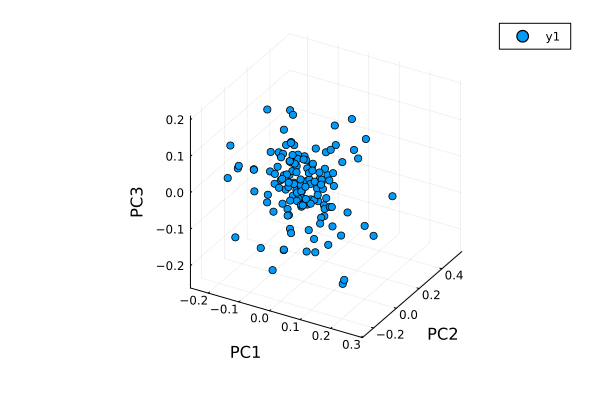

In [52]:
# setosa = Y[:,Xte_labels.=="setosa"]
# versicolor = Y[:,Xte_labels.=="versicolor"]
# virginica = Y[:,Xte_labels.=="virginica"]

p = scatter(Y[1,:], Y[2,:], Y[3,:], marker=:circle,linewidth=0)
# scatter!(versicolor[1,:],versicolor[2,:],versicolor[3,:],marker=:circle,linewidth=0)
# scatter!(virginica[1,:],virginica[2,:],virginica[3,:],marker=:circle,linewidth=0)
plot!(p,xlabel="PC1", ylabel="PC2", zlabel="PC3")

In [53]:
using Statistics

In [54]:
data

146×18211 Matrix{Float64}:
  0.10472    -0.0775242  -1.6256     …   0.0341268    0.221377    0.368755
  4.29065    -0.0638636  -0.0174432      0.112365    -0.122193    0.676629
  0.861487   -0.112313   -0.355217      -0.141699    -0.75651    -0.0769337
 -0.123917    0.599044   -0.607861       0.424266    -0.324399    0.950834
  0.907017    0.576599   -1.00323        0.655258    -1.23982    -0.154373
 -1.12291     0.156985    0.0973875  …  -0.502262     0.715482    1.60149
  0.407019   -1.30314     0.196037      -0.0757219    0.635269   -0.0806248
 -0.0263513   0.412793   -0.401851       0.639968    -0.243644    1.17567
 -0.194657    0.378838    0.138571      -0.259793     0.531387   -0.0808469
 -0.529644   -0.488751    0.189797      -0.416554     0.474141   -1.3562
  0.441273    0.369219    0.0990749  …   3.27508     -0.492168    0.392183
  1.1628      0.130203   -0.0268157     -0.00636921   0.0384489   0.322258
 -0.106309    1.5076      0.53831        0.572553    -0.364037   -0.19693


In [55]:
transpose(Y)

146×100 transpose(::Matrix{Float64}) with eltype Float64:
 -0.00785469   -0.0397305   -0.00180896   …  -0.00513138   0.00160754
 -0.0032721    -0.0140067   -0.00622641      -0.00407647  -0.0111368
 -0.00305806    0.0220136    0.000319825      0.00328822   0.00887319
 -0.00175967   -0.0107072   -0.0126157       -0.00904792  -0.0155903
 -0.0377259    -0.272863    -0.104844        -0.11994     -0.120558
  0.00939458   -0.0420778   -0.0182943    …  -0.0136028   -0.0118175
 -0.000251862   0.54932     -0.0194233        0.00559287   0.000908937
  0.00825824    0.00520583   0.0118354        0.00359341   0.0262723
 -0.0361081     0.308671    -0.0619121       -0.0430727   -0.0674627
 -0.0126915    -0.0577874   -0.0134949       -0.0198321   -0.0365896
  0.0150556     0.079836    -0.0243898    …  -0.0705395    0.0696694
 -0.0619607    -0.0166577   -0.0585376        0.0544732    0.00421137
  0.105269     -0.094091     0.0986902        0.0659928    0.0337083
  ⋮                                      

In [63]:
# Standardize down data
m = mean(Y)
s = std(Y)

Z = (Y .- m)

100×146 Matrix{Float64}:
 -0.00693857   -0.00235598   -0.00214193   …   0.0254483   -0.098919
 -0.0388143    -0.0130906     0.0229297        0.0140206    0.0183625
 -0.000892837  -0.00531029    0.00123595       0.0460241    0.00565934
  0.00042198   -0.00141402    0.00249436       0.0468185    0.0493717
 -0.019576     -0.00273628   -0.00436364       0.0440243    0.00396328
 -0.00678338   -0.0012691     0.000464826  …  -0.0131804    0.066753
 -0.0163939     0.00409434   -0.0043748       -0.00679499   0.0144278
 -0.0197693    -0.0005471     0.000474827      0.0206876   -0.0244176
 -0.00816767    0.0013248    -0.000687226      0.0984704    0.0133471
 -0.00974144    0.00308978   -0.000392743     -0.0849872   -0.0168195
 -0.00662957   -0.00564417    0.00804709   …   0.0348312   -0.0400188
 -0.0239564    -0.00026733   -0.000855906      0.0305329    0.0524162
 -0.00173876   -0.000995253   0.00263684       0.021531     0.0102647
  ⋮                                        ⋱                ⋮
 -0

In [64]:
c = cov(Z)

146×146 Matrix{Float64}:
  0.00811214   -0.00032643    0.000403162  …  -3.08066e-5    0.000251978
 -0.00032643    0.00861345    0.0024466       -3.36039e-5    5.195e-5
  0.000403162   0.0024466     0.00553499       4.56222e-5   -1.58109e-5
 -4.09718e-5   -0.00221965    0.00422664      -4.22976e-5   -6.42752e-5
 -0.00177461   -0.000556614  -0.000347517     -0.000188776   0.00010893
  0.000694605   0.0001638    -0.000470486  …  -6.69547e-5   -0.00016381
  3.32529e-5    9.70203e-5   -3.74532e-5      -5.27664e-5   -9.08893e-5
  0.000470477   0.000205281  -0.000708014      4.53891e-6    0.000144896
 -0.00109053   -0.000475022   5.6393e-5        1.30792e-5   -0.000127233
  0.00012547    0.000181029  -0.000224027      7.86115e-6   -0.000233016
  0.000383241   3.19003e-5    0.000152462  …  -0.000215781   0.000108376
 -0.000340721   0.000199147  -5.96771e-5      -6.59374e-5   -9.13232e-5
  0.00106007    0.000101274  -9.41758e-5      -2.78018e-5   -0.000104563
  ⋮                                

In [65]:
size(c,2)

146

In [66]:
cslice = view(c, 1:100, 1:100)

100×100 view(::Matrix{Float64}, 1:100, 1:100) with eltype Float64:
  0.00811214   -0.00032643    0.000403162  …   9.31545e-5    0.000209124
 -0.00032643    0.00861345    0.0024466       -1.82546e-5    3.08663e-5
  0.000403162   0.0024466     0.00553499       9.44416e-6   -9.85236e-6
 -4.09718e-5   -0.00221965    0.00422664      -2.89458e-5    1.53725e-5
 -0.00177461   -0.000556614  -0.000347517      0.000225876   0.000213666
  0.000694605   0.0001638    -0.000470486  …  -0.000169594   1.6748e-5
  3.32529e-5    9.70203e-5   -3.74532e-5      -7.61565e-5   -9.07861e-5
  0.000470477   0.000205281  -0.000708014      0.000246751   6.75845e-5
 -0.00109053   -0.000475022   5.6393e-5        0.000262051   1.17586e-6
  0.00012547    0.000181029  -0.000224027     -9.01071e-5   -7.60754e-5
  0.000383241   3.19003e-5    0.000152462  …  -4.55604e-6   -0.000139053
 -0.000340721   0.000199147  -5.96771e-5      -7.6635e-5     0.000247094
  0.00106007    0.000101274  -9.41758e-5      -0.000203688  -7.863

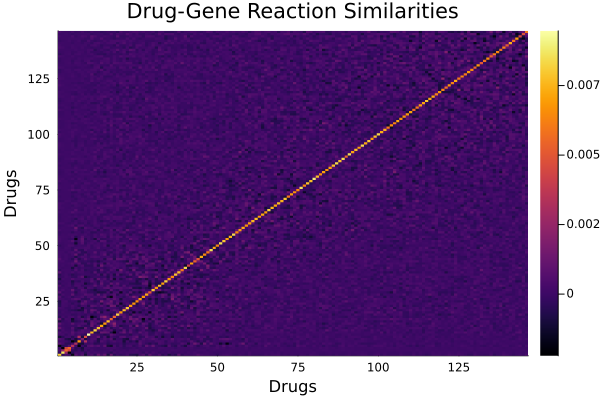

In [77]:
heatmap(1:size(c,1),
    1:size(c,2), c,
    xlabel="Drugs", ylabel="Drugs",
    title="Drug-Gene Reaction Similarities")

In [68]:
using Pkg;
Pkg.add("JSON")
using JSON

   Resolving package versions...
  No Changes to `C:\Users\sarah\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\sarah\.julia\environments\v1.9\Manifest.toml`


In [69]:
dframe[!, "sm_name"]

146-element Vector{String}:
 "Clotrimazole"
 "Mometasone Furoate"
 "Idelalisib"
 "Vandetanib"
 "Bosutinib"
 "Ceritinib"
 "Lamivudine"
 "Crizotinib"
 "Cabozantinib"
 "Flutamide"
 "Dasatinib"
 "Selumetinib"
 "Trametinib"
 ⋮
 "AMD-070 (hydrochloride)"
 "BMS-265246"
 "Tipifarnib"
 "Imatinib"
 "Topotecan"
 "Clemastine"
 "5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine"
 "CGM-097"
 "TGX 221"
 "Azacitidine"
 "Atorvastatin"
 "Riociguat"

In [122]:
Y[:,1]

100-element Vector{Float64}:
 -0.007854692390914186
 -0.039730459293610396
 -0.0018089621860812779
 -0.0004941448012519147
 -0.020492155604256906
 -0.007699508986355053
 -0.017310027631651483
 -0.02068538377711945
 -0.009083796381501428
 -0.010657565739252643
 -0.0075456970147863
 -0.024872492093262182
 -0.002654881556433062
  ⋮
 -0.35449745694879364
  0.005252642356799264
  0.0032170151926928627
 -0.021050341933636925
 -0.03226517337543574
 -0.0024879748870631846
 -0.01225941488842234
 -0.007626806495892463
 -0.0036607493957224757
  0.008794571253641595
 -0.005131379766843473
  0.0016075426580952241

In [180]:
# Let's label points by their corresponding EPC (pharmacologic class) if available, else grey
# (1) Load drug information
info = JSON.parsefile("drug_information_indexed.json")

# (3) Map these to colors
map = Dict(
    "Azole Antifungal [EPC]"=>"red",
    nothing=>"grey",
    "Kinase Inhibitor [EPC]"=>"green",
    "Hepatitis B Virus Nucleoside Analog Reverse Transcriptase Inhibitor [EPC]"=>"purple",
    "Androgen Receptor Inhibitor [EPC]"=>"thistle",
    "Histone Deacetylase Inhibitor [EPC]"=>"indigo",
    "Dipeptidyl Peptidase 4 Inhibitor [EPC]"=>"dodgerblue",
    "Aldehyde Dehydrogenase Inhibitor [EPC]"=>"olive",
    "Alkaloid [EPC]"=>"cyan",
    "Antimycobacterial [EPC]"=>"blue",
    "Nucleoside Metabolic Inhibitor [EPC]"=>"pink",
    "Antimetabolite [EPC]"=>"orange",
    "Thalidomide Analog [EPC]"=>"yellow",
    "Histamine-1 Receptor Antagonist [EPC]"=>"violet",
    "Soluble Guanylate Cyclase Stimulator [EPC]"=>"aquamarine",
    "Corticosteroid [EPC]"=>"lightcoral"
)

map_2 = Dict(
    "Azole Antifungal [EPC]"=>[],
    nothing=>[],
    "Kinase Inhibitor [EPC]"=>[],
    "Hepatitis B Virus Nucleoside Analog Reverse Transcriptase Inhibitor [EPC]"=>[],
    "Androgen Receptor Inhibitor [EPC]"=>[],
    "Histone Deacetylase Inhibitor [EPC]"=>[],
    "Dipeptidyl Peptidase 4 Inhibitor [EPC]"=>[],
    "Aldehyde Dehydrogenase Inhibitor [EPC]"=>[],
    "Alkaloid [EPC]"=>[],
    "Antimycobacterial [EPC]"=>[],
    "Nucleoside Metabolic Inhibitor [EPC]"=>[],
    "Antimetabolite [EPC]"=>[],
    "Thalidomide Analog [EPC]"=>[],
    "Histamine-1 Receptor Antagonist [EPC]"=>[],
    "Soluble Guanylate Cyclase Stimulator [EPC]"=>[],
    "Corticosteroid [EPC]"=>[]
)

# (2) Get SM names + replace with 4th column
coloring = []
i = 0
for drug in dframe[!, "sm_name"]
    if info[drug][3] != nothing
        push!(map_2[info[drug][3]], Y[:,i+1])
        push!(coloring, map[info[drug][3]])
    end
    i += 1
end

coloring

30-element Vector{Any}:
 "red"
 "lightcoral"
 "green"
 "green"
 "green"
 "purple"
 "green"
 "green"
 "thistle"
 "green"
 "indigo"
 "dodgerblue"
 "green"
 ⋮
 "red"
 "orange"
 "lightcoral"
 "indigo"
 "green"
 "green"
 "yellow"
 "green"
 "green"
 "violet"
 "pink"
 "aquamarine"

In [200]:
map_2["Corticosteroid [EPC]"]

2-element Vector{Any}:
 [-0.00327210380876862, -0.01400673162784477, -0.006226412824843153, -0.0023301491431550747, -0.003652400822907069, -0.0021852241783880426, 0.003178214376424636, -0.0014632252419611112, 0.0004086801820034592, 0.002173652312314982  …  -0.0037208034638670116, -0.0017699081268610782, -0.024854758701757452, -0.0020211992085132227, -0.005649899387523332, -0.006577775134390261, -0.004028191715369069, -0.005212877638905925, -0.00407646825887202, -0.011136776827465236]
 [0.04539944518756575, 0.0034467986159355535, -0.014087011284327364, -0.019913074581104067, 0.04720622126203389, -0.018850477012818955, 0.05539705834809343, -0.16956725016748866, -0.061071785206852094, 0.09039676476441323  …  0.007907353016324017, -0.061059308828914555, -0.015926854158331644, 0.044999684466858716, -0.06533603380220124, 0.08036611256053128, 0.11010919216836468, -0.0634721448728676, 0.06762604061224059, 0.064085231399846]

In [80]:
unique(coloring)

16-element Vector{Any}:
 "red"
 "lightcoral"
 "green"
 "grey"
 "purple"
 "thistle"
 "indigo"
 "dodgerblue"
 "olive"
 "cyan"
 "blue"
 "pink"
 "orange"
 "yellow"
 "violet"
 "aquamarine"

In [81]:
Y[1,:]

146-element Vector{Float64}:
 -0.007854692390914186
 -0.00327210380876862
 -0.003058058130655187
 -0.0017596692636825204
 -0.03772593877959746
  0.009394576824121377
 -0.0002518622397167204
  0.008258237225841014
 -0.036108050962057575
 -0.012691493829466403
  0.015055556777087167
 -0.06196068544745876
  0.10526879643965928
  ⋮
 -0.03420845179470764
 -0.08367556395600854
 -0.09050143839209682
 -0.10580511992124926
  0.0927557651333831
  0.025397168741350947
  0.006920650561764198
 -0.045693741280919735
  0.10311815322064552
 -0.04434969900191096
  0.024532126350838148
 -0.09983508770037797

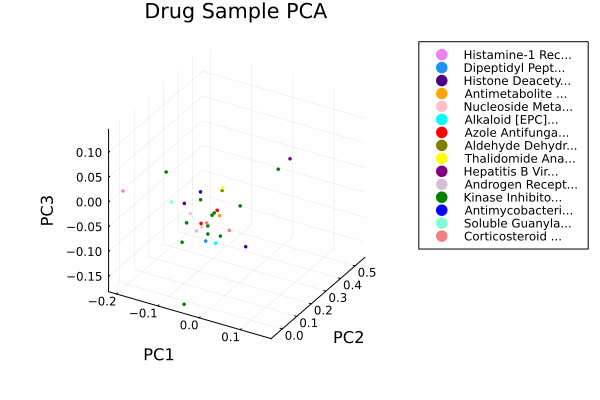

In [230]:
# Let's label points by their corresponding EPC (pharmacologic class) if available, else grey

plot(xlabel="PC1", ylabel="PC2", zlabel="PC3", title="Drug Sample PCA", legend = :outertopright)
# p = scatter(Y[1,:], Y[2,:], Y[3,:], marker=:circle, markersize=2, markerstrokewidth=0, c=coloring, label=false, linewidth=0)
for (name, Y) in map_2
    if name == nothing
        continue
    end
    # Get principal components
    a, b, c = [], [], []
    for i in Y
        push!(a, i[1])
        push!(b, i[2])
        push!(c, i[3])
    end
    scatter!(a, b, c, marker=:circle, markersize=2, markerstrokewidth=0, label=first(name, 15) * "...", color=map[name], linewidth=0)
end
# scatter!(versicolor[1,:],versicolor[2,:],versicolor[3,:],marker=:circle,linewidth=0)
# scatter!(virginica[1,:],virginica[2,:],virginica[3,:],marker=:circle,linewidth=0)
# plot!(xlabel="PC1", ylabel="PC2", zlabel="PC3", title="Drug Sample PCA", legend = :outertopright)
plot!()